In [232]:
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
plt.rc('font', size=14)

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

import matplotlib.ticker as ticker


In [233]:
# load dataset
train_df = pd.read_csv('/Users/gawain/Desktop/线上DS辅导/5. 梯度提升树/LightGBM与XGBoost对比/taitanic-kaggle/train.csv')
test_df = pd.read_csv('/Users/gawain/Desktop/线上DS辅导/5. 梯度提升树/LightGBM与XGBoost对比/taitanic-kaggle/test.csv')

In [234]:
train_df['Age'].fillna(train_df['Age'].median(skipna=True), inplace=True)
print(train_df['Age'].isnull().sum())

train_df['Embarked'].fillna("S", inplace=True)
print(train_df['Embarked'].isnull().sum())

train_df = train_df.drop(columns=['Cabin'])

0
0


### Fare

In [235]:
# Fare

def generate_Fare_categories(train_df):
      Fare_cat = train_df["Fare"]
      Fare_cat_copy = Fare_cat.copy()

      for i in range(len(Fare_cat)):
            if Fare_cat[i] <= 10:
                  Fare_cat_copy[i] = 0
            elif Fare_cat[i] > 10 and Fare_cat[i] <= 50:
                  Fare_cat_copy[i] = 1
            elif Fare_cat[i] > 50 and Fare_cat[i] <= Fare_cat.max():
                  Fare_cat_copy[i] = 2
                  
      Fare_cat_copy.value_counts()
      Fare_df = pd.DataFrame(Fare_cat_copy)
      print(Fare_df.value_counts())
      
      train_df = train_df.drop(columns=['Fare'])
      train_df['Fare'] = Fare_df['Fare']
      return train_df    

In [236]:
train_df = generate_Fare_categories(train_df)
print("\n")
train_df['Fare'].value_counts()

Fare
1.0     395
0.0     336
2.0     160
dtype: int64




1.0    395
0.0    336
2.0    160
Name: Fare, dtype: int64

### Age

In [237]:
# Age

def generate_Age_categories(train_df):
      train_df['Age'] = train_df['Age'].astype(int)
      cat = train_df['Age']
      # cat_copy = cat.copy()
      cat_copy = []

      for i in range(len(train_df['Age'])):
            if train_df['Age'][i] <= 10:
                  cat_copy.append(0)
            elif train_df['Age'][i] > 10 and train_df['Age'][i] <= 30:
                  cat_copy.append(1)
            elif train_df['Age'][i] > 30 and train_df['Age'][i] <= cat.max():
                  cat_copy.append(2)
                  
      Age_df = pd.DataFrame(cat_copy,columns=['Age'])
      print(len(Age_df))
      print(Age_df.value_counts())
      
      train_df = train_df.drop(columns=['Age'])
      train_df['Age'] = Age_df['Age']
      return train_df    

In [238]:
train_df = generate_Age_categories(train_df)
train_df['Age'].value_counts()

891
Age
1      524
2      303
0       64
dtype: int64


1    524
2    303
0     64
Name: Age, dtype: int64

### Sex

In [239]:
# Sex

def generate_Sex_categories(train_df):
      cat_copy = []

      for i in range(len(train_df['Sex'])):
            if train_df['Sex'][i] == 'male':
                  cat_copy.append(1)
            else:
                  cat_copy.append(0)
            
                  
      Sex_df = pd.DataFrame(cat_copy,columns=['Sex'])
      print(len(Sex_df))
      print(Sex_df.value_counts())
      
      train_df = train_df.drop(columns=['Sex'])
      train_df['Sex'] = Sex_df['Sex']
      return train_df    


In [240]:
train_df = generate_Sex_categories(train_df)
train_df['Sex'].value_counts()

891
Sex
1      577
0      314
dtype: int64


1    577
0    314
Name: Sex, dtype: int64

### Parch SibSp

In [241]:
# Parch SibSp

train_df['Family_Size']=0
train_df['Family_Size']=train_df['Parch']+train_df['SibSp']#family size
train_df['Alone']=0
train_df.loc[train_df.Family_Size==0,'Alone']=1#Alone

for i in range(len(train_df)):
      if (train_df['Family_Size'][i] > 0 and train_df['Family_Size'][i] <= 3): # 存活概率较大
            train_df['Family_Size'][i] = 1
      if train_df['Family_Size'][i] > 3: # 存活概率较小
            train_df['Family_Size'][i] = 2
      # 0 为仅仅一人，我们单独放进了“Alone”中

### Name & Embarked

In [242]:
# Name & Embarked
train_df_copy = train_df.copy()

train_df_copy['Initial']=0
for i in train_df_copy:
      train_df_copy['Initial']=train_df_copy.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
      
train_df_copy['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
                        inplace=True)

# train_df_copy['Sex'].replace(['male','female'],[0,1],inplace=True)
train_df_copy['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train_df_copy['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)
train_df_copy.head()

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial
0,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,0,0.0,1,1,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,1,2.0,2,0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,0,0.0,1,0,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,0,2.0,2,0,1,0,1
4,5,0,3,"Allen, Mr. William Henry",0,0,373450,0,0.0,2,1,0,1,0


### Ticket

In [243]:
train_df_copy[train_df_copy['Ticket']=='24160'].head()

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial
689,690,1,1,"Madill, Miss. Georgette Alexandra",0,1,24160,0,2.0,1,0,1,0,2
730,731,1,1,"Allen, Miss. Elisabeth Walton",0,0,24160,0,2.0,1,0,0,1,2
779,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",0,1,24160,0,2.0,2,0,1,0,1


In [244]:
len(train_df_copy)

891

In [245]:
train_df_copy['Ticket'].nunique()

681

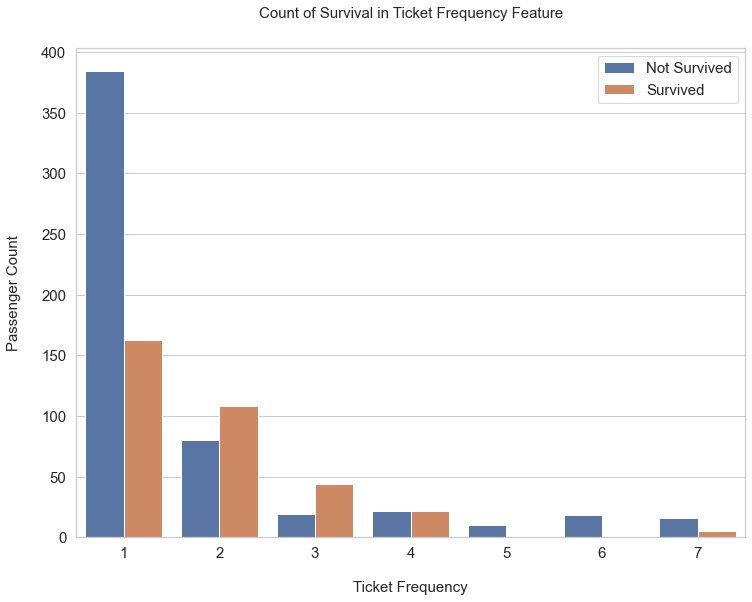

In [246]:
# Ticket

train_df_copy['Ticket_Frequency'] = train_df_copy.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=train_df_copy)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### Title & isMarried & titleRank

In [247]:
# Mme. --> Madame (French for Mrs)
# Mlle --> the French equivalent of Miss
# Col. --> colonel 上校
# the Countess --> the wife or widow of an earl or count 伯爵或伯爵的妻子或寡妇
# Jonkheer --> 领主（最低级别的贵族）
# Rev. --> Reverend is a title used before the name or rank of an officially appointed religious leader 牧师
# Dona. --> a Spanish title of address equivalent to Mrs or Madam
# Master. --> crew members in the titantic (sailing masters)

In [248]:
# Title & isMarried

train_df_copy['Title'] = train_df_copy['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
train_df_copy['Female_Married'] = 0
train_df_copy['Female_Married'].loc[train_df_copy['Title'] == 'Mrs'] = 1
train_df_copy['Female_Married'].loc[train_df_copy['Title'] == 'Mme'] = 1
train_df_copy['Female_Married'].loc[train_df_copy['Title'] == 'the Countess'] = 1
train_df_copy['Female_Married'].loc[train_df_copy['Title'] == 'Dona'] = 1


### titleRank

In [249]:
# Mme. --> Madame (French for Mrs)
# the Countess --> the wife or widow of an earl or count 伯爵或伯爵的妻子或寡妇
# Dona. --> a Spanish title of address equivalent to Mrs or Madam


# Mlle --> the French equivalent of Miss
# Col. --> colonel 上校
# Jonkheer --> 领主（最低级别的贵族）
# Rev. --> Reverend is a title used before the name or rank of an officially appointed religious leader 牧师
# Master. --> crew members in the titantic (sailing masters) 水手
# Major --> a title used by the military少校
# Don -> Synonyms for don include Capo Crimini, which means super boss in Italian

In [250]:
['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess','Jonkheer']


# 设置三个等级
# 平民            --> 0
      # Mr
      # Mrs
      # Miss
      # Mme
      # Ms
      # Mlle

# middle class   --> 1
      # Col
      # Major
      # Master
      # Dr
      # Capt
      # Don

# high class      --> 2
      # the Countess
      # Jonkheer
      # Rev
      # Sir
      # Lady


['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'the Countess',
 'Jonkheer']

In [251]:
def change_title_rank(x):
      title_general_class = ['Mr', 'Mrs', 'Miss', 'Mme', 'Ms', 'Mlle']
      title_middle_class = ['Col', 'Major', 'Master', 'Dr', 'Capt', 'Don']
      title_high_class = ['the Countess', 'Jonkheer', 'Rev', 'Sir', 'Lady']
      if x in title_general_class:
            return 0
      elif x in title_middle_class:
            return 1
      elif x in title_high_class:
            return 2
      else:
            return 3

In [252]:
title_general_class = ['Mr', 'Mrs', 'Miss', 'Mme', 'Ms', 'Mlle']
title_middle_class = ['Col', 'Major', 'Master', 'Dr', 'Capt', 'Don']
title_high_class = ['the Countess', 'Jonkheer', 'Rev', 'Sir', 'Lady']

train_df_copy['title_rank'] = 0
train_df_copy['title_rank'] = train_df_copy['Title'].apply(change_title_rank)


In [253]:
train_df_copy['title_rank'].value_counts()

0    828
1     53
2     10
Name: title_rank, dtype: int64

In [254]:
train_df_copy[train_df_copy['title_rank'] == 2]

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",0,0,244310,0,1.0,2,1,0,1,4,1,Rev,0,2
150,151,0,2,"Bateman, Rev. Robert James",0,0,S.O.P. 1166,0,1.0,2,1,0,1,4,1,Rev,0,2
249,250,0,2,"Carter, Rev. Ernest Courtenay",1,0,244252,0,1.0,2,1,1,0,4,2,Rev,0,2
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",1,0,11755,1,1.0,2,0,1,0,1,1,Lady,0,2
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",1,0,PC 17485,1,2.0,2,1,1,0,0,2,Sir,0,2
626,627,0,2,"Kirkland, Rev. Charles Leonard",0,0,219533,2,1.0,2,1,0,1,4,1,Rev,0,2
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",0,0,110152,0,2.0,2,0,0,1,1,3,the Countess,1,2
822,823,0,1,"Reuchlin, Jonkheer. John George",0,0,19972,0,0.0,2,1,0,1,4,1,Jonkheer,0,2
848,849,0,2,"Harper, Rev. John",0,1,248727,0,1.0,1,1,1,0,4,3,Rev,0,2
886,887,0,2,"Montvila, Rev. Juozas",0,0,211536,0,1.0,1,1,0,1,4,1,Rev,0,2


### 各种title的信息

In [255]:
train_df_copy[train_df_copy['Title']== 'Lady']
# Duff Gordon, Lady, 她老公是Sir


,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",1,0,11755,1,1.0,2,0,1,0,1,1,Lady,0,2


In [256]:
train_df_copy[train_df_copy['Title']== 'Major']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
449,450,1,1,"Peuchen, Major. Arthur Godfrey",0,0,113786,0,1.0,2,1,0,1,0,1,Major,0,1
536,537,0,1,"Butt, Major. Archibald Willingham",0,0,113050,0,1.0,2,1,0,1,0,1,Major,0,1


In [257]:
train_df_copy[train_df_copy['Title']== 'Sir']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",1,0,PC 17485,1,2.0,2,1,1,0,0,2,Sir,0,2


In [258]:
train_df_copy[train_df_copy['Title']== 'Master'].head()
# Dr. Alan Scarth, in his book Titanic and Liverpool, identifies 115 crew members with close connections to the city, of whom only 28 survived.

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
7,8,0,3,"Palsson, Master. Gosta Leonard",3,1,349909,0,1.0,0,1,2,0,3,4,Master,0,1
16,17,0,3,"Rice, Master. Eugene",4,1,382652,2,1.0,0,1,2,0,3,5,Master,0,1
50,51,0,3,"Panula, Master. Juha Niilo",4,1,3101295,0,1.0,0,1,2,0,3,6,Master,0,1
59,60,0,3,"Goodwin, Master. William Frederick",5,2,CA 2144,0,1.0,1,1,2,0,3,6,Master,0,1
63,64,0,3,"Skoog, Master. Harald",3,2,347088,0,1.0,0,1,2,0,3,6,Master,0,1


In [259]:
train_df_copy[train_df_copy['Title']== 'Rev']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",0,0,244310,0,1.0,2,1,0,1,4,1,Rev,0,2
150,151,0,2,"Bateman, Rev. Robert James",0,0,S.O.P. 1166,0,1.0,2,1,0,1,4,1,Rev,0,2
249,250,0,2,"Carter, Rev. Ernest Courtenay",1,0,244252,0,1.0,2,1,1,0,4,2,Rev,0,2
626,627,0,2,"Kirkland, Rev. Charles Leonard",0,0,219533,2,1.0,2,1,0,1,4,1,Rev,0,2
848,849,0,2,"Harper, Rev. John",0,1,248727,0,1.0,1,1,1,0,4,3,Rev,0,2
886,887,0,2,"Montvila, Rev. Juozas",0,0,211536,0,1.0,1,1,0,1,4,1,Rev,0,2


In [260]:
train_df_copy[train_df_copy['Title']== 'Don']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
30,31,0,1,"Uruchurtu, Don. Manuel E",0,0,PC 17601,1,1.0,2,1,0,1,0,1,Don,0,1


In [261]:
train_df_copy[train_df_copy['Title']== 'Mme']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
369,370,1,1,"Aubart, Mme. Leontine Pauline",0,0,PC 17477,1,2.0,1,0,0,1,2,2,Mme,1,0


In [262]:
train_df_copy[train_df_copy['Title']== 'Mlle']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
641,642,1,1,"Sagesser, Mlle. Emma",0,0,PC 17477,1,2.0,1,0,0,1,2,2,Mlle,0,0
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",0,0,PC 17482,1,1.0,1,0,0,1,2,1,Mlle,0,0


In [263]:
train_df_copy[train_df_copy['Title']== 'Col']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",0,0,13213,1,1.0,2,1,0,1,4,1,Col,0,1
694,695,0,1,"Weir, Col. John",0,0,113800,0,1.0,2,1,0,1,4,1,Col,0,1


In [264]:
train_df_copy[train_df_copy['Title']== 'Capt']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
745,746,0,1,"Crosby, Capt. Edward Gifford",1,1,WE/P 5735,0,2.0,2,1,1,0,0,2,Capt,0,1


In [265]:
train_df_copy[train_df_copy['Title']== 'the Countess']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",0,0,110152,0,2.0,2,0,0,1,1,3,the Countess,1,2


In [266]:
train_df_copy[train_df_copy['Title']== 'Jonkheer']

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Title,Female_Married,title_rank
822,823,0,1,"Reuchlin, Jonkheer. John George",0,0,19972,0,0.0,2,1,0,1,4,1,Jonkheer,0,2


### Title rank feature rebuild

### 相关性


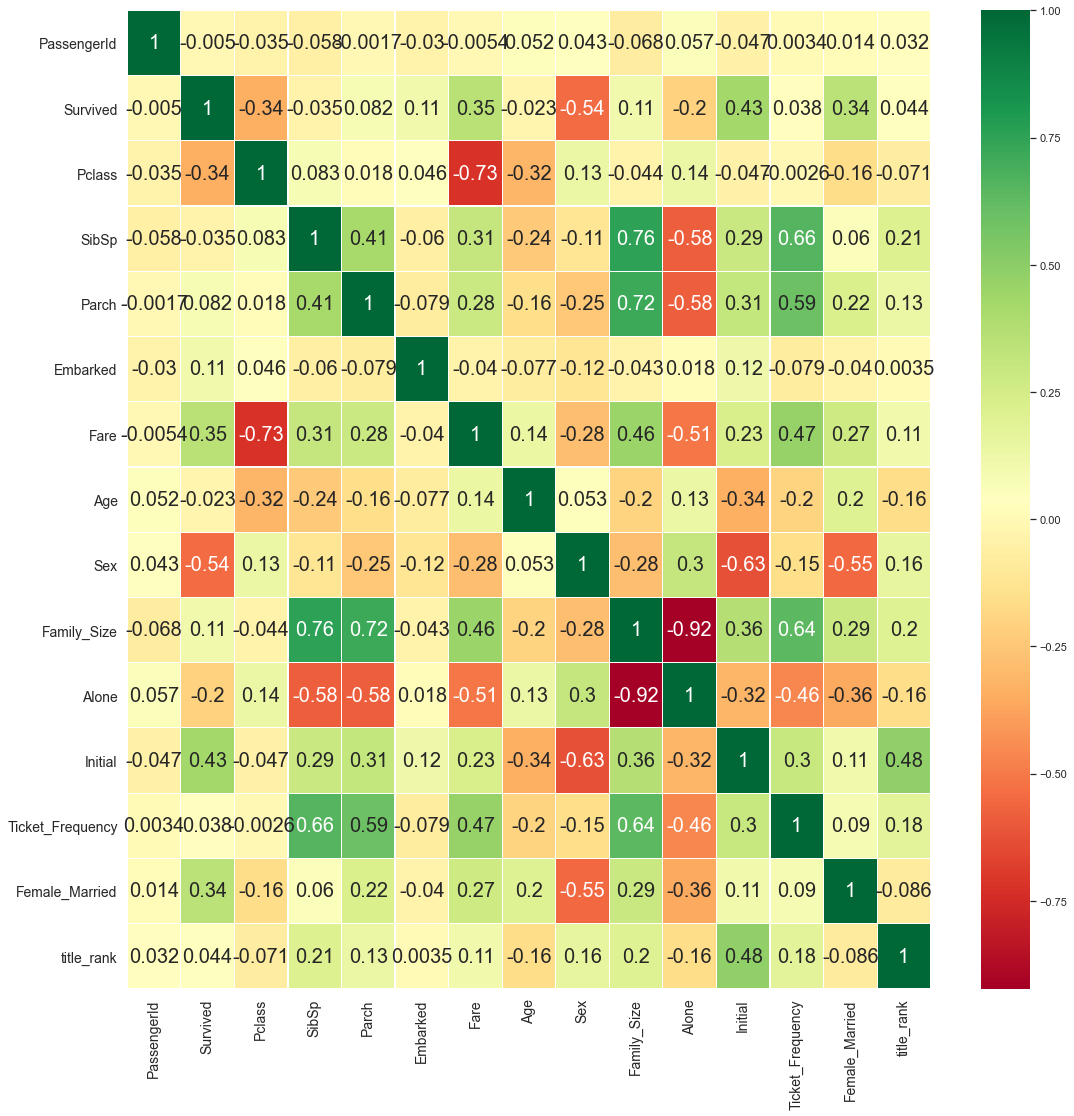

In [267]:
# 相关性

sns.heatmap(train_df_copy.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Feature Cross

In [268]:
# # Pclass      Embarked	Fare	Age	Sex	Family_Size	Alone	
# Pclass_cross = tf.feature_column.numeric_column('households')


In [269]:
# import tensorflow as tf
# sess= tf.compat.v1.Session()
# #特征数据
# features = {
#       'gender': [0, 1, 1, 0, 1],
#       'games': ['sport', 'sport', 'drawing', 'gardening', 'travelling'],
# }

# #特征列
# department = tf.feature_column.categorical_column_with_vocabulary_list('games', ['sport','drawing','gardening','travelling'], dtype=tf.string)
# sex = tf.feature_column.categorical_column_with_identity('gender', num_buckets=2, default_value=0)
# sex_department = tf.feature_column.crossed_column([department,sex], 8)
# sex_department = tf.feature_column.indicator_column(sex_department)
# #组合特征列
# columns = [
#       sex_department
# ]
# #输入层（数据，特征列）
# inputs = tf.feature_column.input_layer(features, columns)
# #初始化并运行
# init = tf.global_variables_initializer()
# sess.run(tf.tables_initializer())
# sess.run(init)
# v=sess.run(inputs)
# print(v)

# Modeling

模型总结
- svm.SVC: SVC(C=0.4, gamma=0.1, kernel='linear')       

                                                -> 0.8136651810934655
- LightGBM Model accuracy score                      

                                                -> 0.8156
- RandomForestClassifier(random_state=0)         

                                                -> 0.793559726319754
- Naive Bayes	                                 

                                                -> 0.794744
- LogisticRegression                                        

                                                -> 0.8044692737430168

In [270]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [271]:
df_copy = train_df_copy.copy()
df_copy = df_copy.drop(columns=['Name','Ticket','Title'])
X = df_copy
y = df_copy['Survived']
X.drop(['Survived'],axis=1,inplace=True)
x_train, x_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

x_train.head()

,PassengerId,Pclass,SibSp,Parch,Embarked,Fare,Age,Sex,Family_Size,Alone,Initial,Ticket_Frequency,Female_Married,title_rank
140,141,3,0,2,1,1.0,1,0,1,0,1,2,1,0
439,440,2,0,0,0,1.0,2,1,0,1,0,1,0,0
817,818,2,1,1,1,1.0,2,1,1,0,0,2,0,0
378,379,3,0,0,1,0.0,1,1,0,1,0,1,0,0
491,492,3,0,0,0,0.0,1,1,0,1,0,1,0,0


In [272]:
model = LogisticRegression()
model.fit(x_train,y_train)
prediction3=model.predict(x_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_test))

The accuracy of the Logistic Regression is 0.7988826815642458


In [273]:
model=GaussianNB()
model.fit(x_train,y_train)
prediction6=model.predict(x_test)
print('The accuracy of the Naive Bayes is',metrics.accuracy_score(prediction6,y_test))

The accuracy of the Naive Bayes is 0.7932960893854749


In [274]:
model=RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)
prediction7=model.predict(x_test)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,y_test))

The accuracy of the Random Forests is 0.8100558659217877


In [275]:
# SVC(C=0.4, gamma=0.1, kernel='linear')
model = svm.SVC(kernel='linear', C=0.4, gamma=0.1)

In [276]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

# predict the results
y_pred=clf.predict(x_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8212
